### Machine Learning with the Equipment Failure Prediction. 

<h3 style="color:#01308e;">Overview</h3>

**Now I will take the selected/pre-processed/imputed datasets and feed this into different ML models by using cross validation.**

<h3 style="color:#01308e;">Business Problem in machine learning terms:</h3>

**Given the data points with their respective features, use classification to find out whether the data points belong to surface failure or downhole failure.**

<h3 style="color:#01308e;">Metric to be used:</h3>

**F2 Score : ((1 + (2)^2) * Precision * Recall) / (((2)^2 * Precision) + Recall)**

<h3 style="color:#01308e;">Datasets:</h3>

**<u>3 datasets :</u><br><br>
1)Median imputed Median dataset.<br>
2)Median imputed Adasyn dataset.<br>
3)Median imputed Smotetomek dataset.<br><br>
I will feed these 3 datasets into Machine Learning Algorithm.**

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels

In [3]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [4]:
from sklearn.linear_model import SGDClassifier

In [5]:
from sklearn.metrics import fbeta_score

In [6]:
from sklearn.metrics import make_scorer
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)
from sklearn.model_selection import GridSearchCV

In [7]:
import os
os.cpu_count()

8

In [8]:
!nvidia-smi

Mon Nov 23 06:44:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX150       Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P3    N/A /  N/A |    308MiB /  2002MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!cat /usr/local/cuda/version.txt

cat: /usr/local/cuda/version.txt: No such file or directory


In [10]:
!python -V

/bin/bash: python: command not found


**For faster tSNE we use the rapids API to run tSNE and PCA on a GPU.<br>
They directly use the GPU cores provided by both Kaggle and google colab instead of the cpus cores.<br>
Huge increase in runtime speed.<br>
Better not to run in kaggle else you will get stuck after a little while.<br>
Instead run in google colab.**

#For Google Colab
import pynvml
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)
if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
    raise Exception("""
    Unfortunately this instance does not have a T4, P4 or P100 GPU.
    
    Please make sure you've configured Colab to request a GPU instance type.
    
    Sometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100. Resetting the instance.
    
    If you get a K80 GPU, try Runtime -> Reset all runtimes...
    """)
else:
    print('Woo! You got the right kind of GPU!')

%%capture 
#Use this to stop the huge output messages that come while installing.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

import pandas.testing as tm
import cudf, cuml
from cuml import PCA
from cuml.decomposition import PCA
from cuml.manifold import TSNE

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount("/content/gdrive")

**Get the data**

In [12]:
!pwd

/home/a/Desktop/Data


In [13]:
new_standard_train_median_all_features_df=pd.read_pickle("new_standard_train_median_all_features_df.pickle")
y_train_median_all_features=pd.read_pickle("y_train_median_all_features.pickle")
new_standard_test_median_all_features_df=pd.read_pickle("new_standard_test_median_all_features_df.pickle")
y_test_median_all_features=pd.read_pickle("y_test_median_all_features.pickle")

new_x_adasyn_df=pd.read_pickle("new_x_adasyn_df.pickle")
y_adasyn=pd.read_pickle("y_adasyn.pickle")
new_standard_test_adasyn_all_features_df=pd.read_pickle("new_standard_test_adasyn_all_features_df.pickle")
y_test_adasyn_all_features=pd.read_pickle("y_test_adasyn_all_features.pickle")

new_x_smotetomek_df=pd.read_pickle("new_x_smotetomek_df.pickle")
y_smotetomek=pd.read_pickle("y_smotetomek.pickle")
new_standard_test_smotetomek_all_features_df=pd.read_pickle("new_standard_test_smotetomek_all_features_df.pickle")
y_test_smotetomek_all_features=pd.read_pickle("y_test_smotetomek_all_features.pickle")

### KNN

**Using KNN, find the best hyper parameter the gives the best F2 Score**

In [10]:
#KNN.get_params().keys()

In [11]:
def run_KNN(x_train, y_train):
    
    f_2_score = make_scorer(fbeta_score, pos_label=1.0 , beta=2)
    
    k_list=np.arange(1,100,10)

    parameters = {'n_neighbors': k_list}

    KNN = KNeighborsClassifier(n_jobs=-1)

    grid = GridSearchCV(KNN, parameters, n_jobs=-1, cv=5,scoring=f_2_score)

    grid.fit(x_train, y_train) 

    return grid

**KNN on median data**

In [ ]:
%%time
grid=run_KNN(new_standard_train_median_all_features_df, y_train_median_all_features)
grid

CPU times: user 7.25 s, sys: 208 ms, total: 7.46 s
Wall time: 24min 20s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

KNeighborsClassifier(n_jobs=-1, n_neighbors=1)

In [ ]:
grid.best_params_

{'n_neighbors': 1}

In [ ]:
grid.best_score_

0.744656005715562

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,{'n_neighbors': 1},0.744656
1,{'n_neighbors': 11},0.599305
2,{'n_neighbors': 21},0.534970
3,{'n_neighbors': 31},0.509978
4,{'n_neighbors': 41},0.470221


In [ ]:
k_list_median=list(results["param_n_neighbors"])
cv_f2_score_KNN_median_data=list(results["mean_test_score"])

In [ ]:
np.save('k_list_median.npy',k_list_median) 
#k_list_median=np.load("k_list_median.npy")

In [ ]:
np.save('cv_f2_score_KNN_median_data.npy',cv_f2_score_KNN_median_data ) 
#cv_f2_score_KNN_median_data=np.load("cv_f2_score_KNN_median_data.npy")

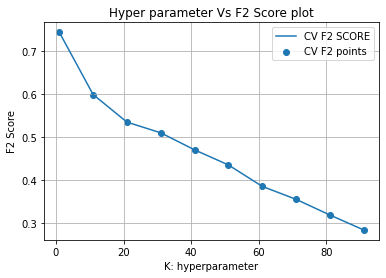

In [ ]:
plt.plot(k_list_median,cv_f2_score_KNN_median_data, label='CV F2 SCORE')

plt.scatter(k_list_median,cv_f2_score_KNN_median_data, label='CV F2 points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**KNN on adasyn data**

In [ ]:
%%time
grid=run_KNN(new_x_adasyn_df,y_adasyn)
grid

CPU times: user 34.7 s, sys: 233 ms, total: 34.9 s
Wall time: 1h 11min 14s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

KNeighborsClassifier(n_jobs=-1, n_neighbors=1)

In [ ]:
grid.best_params_

{'n_neighbors': 1}

In [ ]:
grid.best_score_

0.9831211871253247

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]98078315

,params,mean_test_score
0,{'n_neighbors': 1},0.983121
1,{'n_neighbors': 11},0.977702
2,{'n_neighbors': 21},0.979831
3,{'n_neighbors': 31},0.980783
4,{'n_neighbors': 41},0.980780


In [ ]:
k_list_adasyn=list(results["param_n_neighbors"])
cv_f2_score_KNN_adasyn_data=list(results["mean_test_score"])

In [ ]:
np.save('k_list_adasyn.npy',k_list_adasyn) 
#k_list_adasyn=np.load("k_list_adasyn.npy")

In [ ]:
np.save('cv_f2_score_KNN_adasyn_data.npy',cv_f2_score_KNN_adasyn_data ) 
#cv_f2_score_KNN_adasyn_data=np.load("cv_f2_score_KNN_adasyn_data.npy")

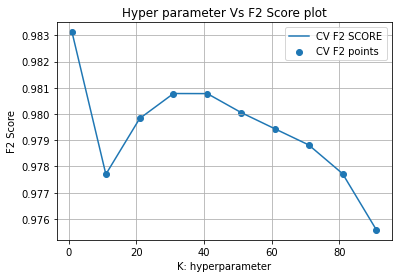

In [ ]:
plt.plot(k_list_adasyn,cv_f2_score_KNN_adasyn_data, label='CV F2 SCORE')

plt.scatter(k_list_adasyn,cv_f2_score_KNN_adasyn_data, label='CV F2 points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**KNN on smotetomek data**

In [ ]:
%%time
grid=run_KNN(new_x_smotetomek_df,y_smotetomek)
grid

CPU times: user 27.8 s, sys: 252 ms, total: 28.1 s
Wall time: 49min 12s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

KNeighborsClassifier(n_jobs=-1, n_neighbors=1)

In [ ]:
grid.best_params_

{'n_neighbors': 1}

In [ ]:
grid.best_score_

0.9980152588027043

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,{'n_neighbors': 1},0.998015
1,{'n_neighbors': 11},0.994369
2,{'n_neighbors': 21},0.992922
3,{'n_neighbors': 31},0.992254
4,{'n_neighbors': 41},0.991534


In [ ]:
k_list_smotetomek=list(results["param_n_neighbors"])
cv_f2_score_KNN_smotetomek_data=list(results["mean_test_score"])

In [ ]:
np.save('k_list_smotetomek.npy',k_list_smotetomek) 
#k_list_smotetomek=np.load("k_list_smotetomek.npy")

In [ ]:
np.save('cv_f2_score_KNN_smotetomek_data.npy',cv_f2_score_KNN_smotetomek_data ) 
#cv_f2_score_KNN_smotetomek_data=np.load("cv_f2_score_KNN_smotetomek_data.npy")

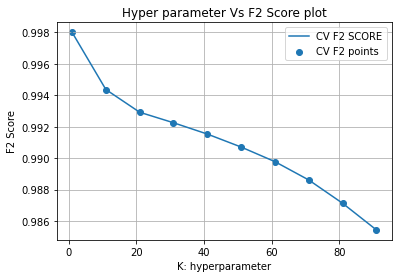

In [ ]:
plt.plot(k_list_smotetomek,cv_f2_score_KNN_smotetomek_data, label='CV F2 SCORE')

plt.scatter(k_list_smotetomek,cv_f2_score_KNN_smotetomek_data, label='CV F2 points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

In [ ]:
np.sort(cv_f2_score_KNN_median_data)[::-1]

array([0.74465601, 0.5993048 , 0.53496971, 0.50997768, 0.47022117,
       0.43504162, 0.3850689 , 0.35481371, 0.31830202, 0.28341554])

In [ ]:
np.sort(cv_f2_score_KNN_adasyn_data)[::-1]

array([0.98312119, 0.98078315, 0.98077989, 0.98005703, 0.97983065,
       0.97943653, 0.97882069, 0.97772492, 0.97770242, 0.97557984])

In [ ]:
np.sort(cv_f2_score_KNN_smotetomek_data)[::-1]

array([0.99801526, 0.99436885, 0.99292246, 0.99225374, 0.99153402,
       0.99070725, 0.98977714, 0.9886102 , 0.9871287 , 0.98543187])

**Trying Test Score with median data set.**

In [14]:
# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    
    true = pd.Series(list(Y_true))
    predicted = pd.Series(list(Y_pred))

    return pd.crosstab(true, predicted, rownames=['True'], colnames=['Predicted'])

In [15]:
KNN = KNeighborsClassifier(11,n_jobs=-1)
#Fit with train data
KNN.fit(new_standard_train_median_all_features_df, y_train_median_all_features)

#Run the prediction with test data.
y_predicted = KNN.predict(new_standard_test_median_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_median_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_median_all_features, y_predicted))

f2_score :  0.6263269639065817
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11776   24
1.0           82  118


**Trying Test Score with adasyn data set.**

In [18]:
KNN = KNeighborsClassifier(31,n_jobs=-1)
#Fit with train data
KNN.fit(new_x_adasyn_df, y_adasyn)

#Run the prediction with test data.
y_predicted = KNN.predict(new_standard_test_adasyn_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_adasyn_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_adasyn_all_features, y_predicted))

f2_score :  0.7014388489208633
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11405  395
1.0            5  195


**The second highest value after all the 1 NN are the 11 NN . So I will take the 11 NN from the smotetomek dataset.**

In [ ]:
KNN = KNeighborsClassifier(11,n_jobs=-1)
#Fit with train data
KNN.fit(new_x_smotetomek_df, y_smotetomek)

#Run the prediction with test data.
y_predicted = KNN.predict(new_standard_test_smotetomek_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_smotetomek_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_smotetomek_all_features, y_predicted))

f2_score :  0.7821457821457822
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11570  230
1.0            9  191


#### We do not use Multinomial Naive Bayes here as Naive Bayes does not take Negative values.
#### We have standardized our data so we cannot use the negative values for the Multinomial Naive Bayes.

### Logistic Regression

**Using Logistic Regression, find the best hyper parameter the gives the best F2 Score**

In [20]:
def run_Logistic_Regression_LR_Lib(x_train, y_train):
    
    f_2_score = make_scorer(fbeta_score, pos_label=1.0 , beta=2)
    
    c_list=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]

    parameters = {'C': c_list}
    
    LR = LogisticRegression(penalty='l1',solver = 'liblinear',class_weight='balanced', max_iter=100,n_jobs=-1)

    grid = GridSearchCV(LR, parameters, n_jobs=-1, cv=5,scoring=f_2_score)

    grid.fit(x_train, y_train) 

    return grid

**LR on median data**

In [ ]:
%%time
grid=run_Logistic_Regression_LR_Lib(new_standard_train_median_all_features_df, y_train_median_all_features)
grid

CPU times: user 22.8 s, sys: 310 ms, total: 23.1 s
Wall time: 1h 57min 31s


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                          penalty='l1', solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1, penalty='l1',
                   solver='liblinear')

In [ ]:
grid.best_params_

{'C': 0.1}

In [ ]:
grid.best_score_

0.7802270537562279

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,{'C': 0.0001},0.277987
1,{'C': 0.001},0.677371
2,{'C': 0.01},0.776801
3,{'C': 0.1},0.780227
4,{'C': 1},0.769950


In [ ]:
c_list_LR_Lib=list(results["param_C"])
cv_f2_score_LR_Lib_median_data=list(results["mean_test_score"])

In [ ]:
np.save('c_list_LR_Lib.npy',c_list_LR_Lib) 
#c_list_LR_Lib=np.load("c_list_LR_Lib.npy")

In [ ]:
np.save('cv_f2_score_LR_Lib_median_data.npy',cv_f2_score_LR_Lib_median_data ) 
#cv_f2_score_LR_Lib_median_data=np.load("cv_f2_score_LR_Lib_median_data.npy")

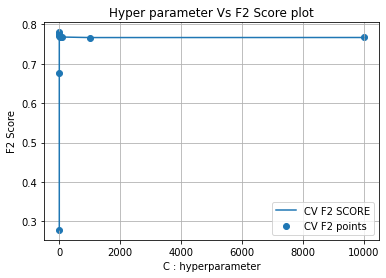

In [ ]:
plt.plot(c_list_LR_Lib,cv_f2_score_LR_Lib_median_data, label='CV F2 SCORE')

plt.scatter(c_list_LR_Lib,cv_f2_score_LR_Lib_median_data, label='CV F2 points')

plt.legend()
plt.xlabel("C : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**LR on adasyn data**

In [ ]:
%%time
grid=run_Logistic_Regression_LR_Lib(new_x_adasyn_df,y_adasyn)
grid

CPU times: user 2min 29s, sys: 368 ms, total: 2min 29s
Wall time: 40min 54s


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                          penalty='l1', solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

LogisticRegression(C=100, class_weight='balanced', n_jobs=-1, penalty='l1',
                   solver='liblinear')

In [ ]:
grid.best_params_

{'C': 100}

In [ ]:
grid.best_score_

0.9373459991660015

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,{'C': 0.0001},0.912588
1,{'C': 0.001},0.928675
2,{'C': 0.01},0.932615
3,{'C': 0.1},0.935372
4,{'C': 1},0.937170


In [ ]:
c_list_LR_Lib=list(results["param_C"])
cv_f2_score_LR_Lib_adasyn_data=list(results["mean_test_score"])

In [ ]:
np.save('c_list_LR_Lib.npy',c_list_LR_Lib) 
#c_list_LR_Lib=np.load("c_list_LR_Lib.npy")

In [ ]:
np.save('cv_f2_score_LR_Lib_adasyn_data.npy',cv_f2_score_LR_Lib_adasyn_data ) 
#cv_f2_score_LR_Lib_adasyn_data=np.load("cv_f2_score_LR_Lib_adasyn_data.npy")

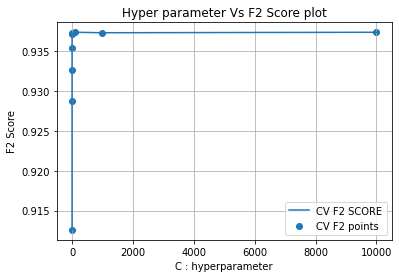

In [ ]:
plt.plot(c_list_LR_Lib,cv_f2_score_LR_Lib_adasyn_data, label='CV F2 SCORE')

plt.scatter(c_list_LR_Lib,cv_f2_score_LR_Lib_adasyn_data, label='CV F2 points')

plt.legend()
plt.xlabel("C : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**LR on smotetomek data**

In [ ]:
%%time
grid=run_Logistic_Regression_LR_Lib(new_x_smotetomek_df,y_smotetomek)
grid

CPU times: user 8.7 s, sys: 288 ms, total: 8.99 s
Wall time: 11min 51s


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                          penalty='l1', solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

LogisticRegression(C=100, class_weight='balanced', n_jobs=-1, penalty='l1',
                   solver='liblinear')

In [ ]:
grid.best_params_

{'C': 100}

In [ ]:
grid.best_score_

0.9668803564746792

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,{'C': 0.0001},0.949509
1,{'C': 0.001},0.951743
2,{'C': 0.01},0.962819
3,{'C': 0.1},0.966287
4,{'C': 1},0.966548


In [ ]:
c_list_LR_Lib=list(results["param_C"])
cv_f2_score_LR_Lib_smotetomek_data=list(results["mean_test_score"])

In [ ]:
np.save('c_list_LR_Lib.npy',c_list_LR_Lib) 
#c_list_LR_Lib=np.load("c_list_LR_Lib.npy")

In [ ]:
np.save('cv_f2_score_LR_Lib_smotetomek_data.npy',cv_f2_score_LR_Lib_smotetomek_data ) 
#cv_f2_score_LR_Lib_smotetomek_data=np.load("cv_f2_score_LR_Lib_smotetomek_data.npy")

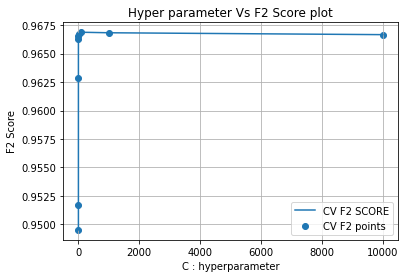

In [ ]:
plt.plot(c_list_LR_Lib,cv_f2_score_LR_Lib_smotetomek_data, label='CV F2 SCORE')

plt.scatter(c_list_LR_Lib,cv_f2_score_LR_Lib_smotetomek_data, label='CV F2 points')

plt.legend()
plt.xlabel("C : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

In [ ]:
np.sort(cv_f2_score_LR_Lib_median_data)[::-1][0]

0.7802270537562279

In [ ]:
np.sort(cv_f2_score_LR_Lib_adasyn_data)[::-1][0]

0.9373459991660015

In [ ]:
np.sort(cv_f2_score_LR_Lib_smotetomek_data)[::-1][0]

0.9668803564746792

In [ ]:
c_list_LR_Lib[np.argsort(cv_f2_score_LR_Lib_smotetomek_data)[::-1][0]]

100

**Running LR_Lib on median data with appropriate hyperparameters**

In [21]:
LR = LogisticRegression(penalty='l1', C=0.1,solver = 'liblinear',class_weight='balanced', max_iter=100,n_jobs=-1)

#Fit with train data
LR.fit(new_standard_train_median_all_features_df, y_train_median_all_features)

#Run the prediction with cv data.
y_predicted = LR.predict(new_standard_test_median_all_features_df)

#Get the F2 Score with cv data.
f2_score=fbeta_score(y_test_median_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_median_all_features, y_predicted))

f2_score :  0.7592891760904684
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11550  250
1.0           12  188


**Running LR_Lib on adasyn data with appropriate hyperparameters**

In [22]:
LR = LogisticRegression(penalty='l1', C=100,solver = 'liblinear',class_weight='balanced', max_iter=100,n_jobs=-1)

#Fit with train data
LR.fit(new_x_adasyn_df, y_adasyn)

#Run the prediction with cv data.
y_predicted = LR.predict(new_standard_test_adasyn_all_features_df)

#Get the F2 Score with cv data.
f2_score=fbeta_score(y_test_adasyn_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_adasyn_all_features, y_predicted))

f2_score :  0.6713132795304476
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11420  380
1.0           17  183


**The best value of cv score is 0.966880 with the c value of 100 with smotetomek data. So I will take this value of c in my algorthim.**

In [ ]:
LR = LogisticRegression(penalty='l1', C=100,solver = 'liblinear',class_weight='balanced', max_iter=100,n_jobs=-1)

#Fit with train data
LR.fit(new_x_smotetomek_df, y_smotetomek)

#Run the prediction with cv data.
y_predicted = LR.predict(new_standard_test_smotetomek_all_features_df)

#Get the F2 Score with cv data.
f2_score=fbeta_score(y_test_smotetomek_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_smotetomek_all_features, y_predicted))

f2_score :  0.739549839228296
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11540  260
1.0           16  184


### Logistic Regression , SGD Library

In [25]:
def run_Logistic_Regression_SGD_Lib(x_train, y_train):
    
    f_2_score = make_scorer(fbeta_score, pos_label=1.0 , beta=2)
    
    a_list=[10**-6,10**-5,10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]

    parameters = {'alpha': a_list}
    
    LR = SGDClassifier(loss='log',penalty='l1',n_jobs=-1,class_weight="balanced")

    grid = GridSearchCV(LR, parameters, n_jobs=-1, cv=5,scoring=f_2_score)

    grid.fit(x_train, y_train) 

    return grid

**LR on median data**

In [ ]:
%%time
grid=run_Logistic_Regression_SGD_Lib(new_standard_train_median_all_features_df, y_train_median_all_features)
grid

CPU times: user 7.25 s, sys: 40.5 ms, total: 7.29 s
Wall time: 4min 53s


GridSearchCV(cv=5,
             estimator=SGDClassifier(class_weight='balanced', loss='log',
                                     n_jobs=-1, penalty='l1'),
             n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100, 1000, 10000]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

SGDClassifier(alpha=1e-06, class_weight='balanced', loss='log', n_jobs=-1,
              penalty='l1')

In [ ]:
grid.best_params_

{'alpha': 1e-06}

In [ ]:
grid.best_score_

0.6997559005548746

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,{'alpha': 1e-06},0.699756
1,{'alpha': 1e-05},0.688018
2,{'alpha': 0.0001},0.629321
3,{'alpha': 0.001},0.576705
4,{'alpha': 0.01},0.400172


In [ ]:
a_list_LR_SGD=list(results["param_alpha"])
cv_f2_score_LR_SGD_median_data=list(results["mean_test_score"])

In [ ]:
np.save('a_list_LR_SGD.npy',a_list_LR_SGD) 
#a_list_LR_SGD=np.load("a_list_LR_SGD.npy")

In [ ]:
np.save('cv_f2_score_LR_SGD_median_data.npy',cv_f2_score_LR_SGD_median_data ) 
#cv_f2_score_LR_SGD_median_data=np.load("cv_f2_score_LR_SGD_median_data.npy")

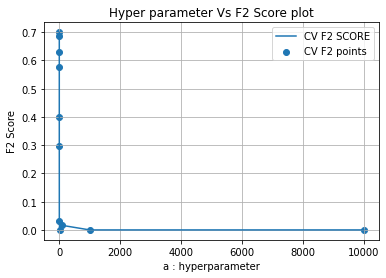

In [ ]:
plt.plot(a_list_LR_SGD,cv_f2_score_LR_SGD_median_data, label='CV F2 SCORE')

plt.scatter(a_list_LR_SGD,cv_f2_score_LR_SGD_median_data, label='CV F2 points')

plt.legend()
plt.xlabel("a : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**LR on adasyn data**

In [ ]:
%%time
grid=run_Logistic_Regression_SGD_Lib(new_x_adasyn_df,y_adasyn)
grid

CPU times: user 1min, sys: 155 ms, total: 1min
Wall time: 4min 44s


GridSearchCV(cv=5,
             estimator=SGDClassifier(class_weight='balanced', loss='log',
                                     n_jobs=-1, penalty='l1'),
             n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100, 1000, 10000]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

SGDClassifier(alpha=1e-05, class_weight='balanced', loss='log', n_jobs=-1,
              penalty='l1')

In [ ]:
grid.best_params_

{'alpha': 1e-05}

In [ ]:
grid.best_score_

0.9302353657989008

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,{'alpha': 1e-06},0.926448
1,{'alpha': 1e-05},0.930235
2,{'alpha': 0.0001},0.921470
3,{'alpha': 0.001},0.918137
4,{'alpha': 0.01},0.920742


In [ ]:
a_list_LR_SGD=list(results["param_alpha"])
cv_f2_score_LR_SGD_adasyn_data=list(results["mean_test_score"])

In [ ]:
np.save('a_list_LR_SGD.npy',a_list_LR_SGD) 
#a_list_LR_SGD=np.load("a_list_LR_SGD.npy")

In [ ]:
np.save('cv_f2_score_LR_SGD_adasyn_data.npy',cv_f2_score_LR_SGD_adasyn_data ) 
#cv_f2_score_LR_SGD_adasyn_data=np.load("cv_f2_score_LR_SGD_adasyn_data.npy")

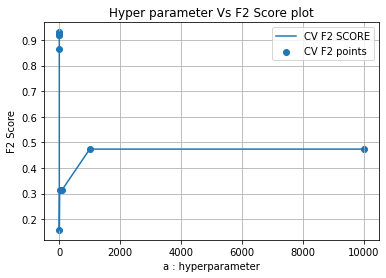

In [ ]:
plt.plot(a_list_LR_SGD,cv_f2_score_LR_SGD_adasyn_data, label='CV F2 SCORE')

plt.scatter(a_list_LR_SGD,cv_f2_score_LR_SGD_adasyn_data, label='CV F2 points')

plt.legend()
plt.xlabel("a : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**LR on smotetomek data**

In [ ]:
%%time
grid=run_Logistic_Regression_SGD_Lib(new_x_smotetomek_df,y_smotetomek)
grid

CPU times: user 2min, sys: 123 ms, total: 2min
Wall time: 5min 4s


GridSearchCV(cv=5,
             estimator=SGDClassifier(class_weight='balanced', loss='log',
                                     n_jobs=-1, penalty='l1'),
             n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100, 1000, 10000]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

SGDClassifier(class_weight='balanced', loss='log', n_jobs=-1, penalty='l1')

In [ ]:
grid.best_params_

{'alpha': 0.0001}

In [ ]:
grid.best_score_

0.9629510403272501

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,{'alpha': 1e-06},0.933178
1,{'alpha': 1e-05},0.961145
2,{'alpha': 0.0001},0.962951
3,{'alpha': 0.001},0.960101
4,{'alpha': 0.01},0.944096


In [ ]:
a_list_LR_SGD=list(results["param_alpha"])
cv_f2_score_LR_SGD_smotetomek_data=list(results["mean_test_score"])

In [ ]:
np.save('a_list_LR_SGD.npy',a_list_LR_SGD) 
#a_list_LR_SGD=np.load("a_list_LR_SGD.npy")

In [ ]:
np.save('cv_f2_score_LR_SGD_smotetomek_data.npy',cv_f2_score_LR_SGD_smotetomek_data ) 
#cv_f2_score_LR_SGD_smotetomek_data=np.load("cv_f2_score_LR_SGD_smotetomek_data.npy")

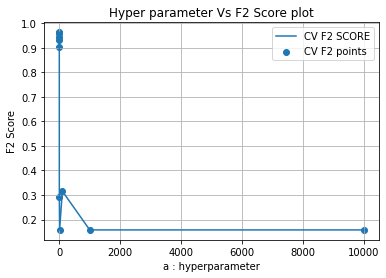

In [ ]:
plt.plot(a_list_LR_SGD,cv_f2_score_LR_SGD_smotetomek_data, label='CV F2 SCORE')

plt.scatter(a_list_LR_SGD,cv_f2_score_LR_SGD_smotetomek_data, label='CV F2 points')

plt.legend()
plt.xlabel("a : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

In [ ]:
np.sort(cv_f2_score_LR_SGD_median_data)[::-1][0]

0.6997559005548746

In [ ]:
np.sort(cv_f2_score_LR_SGD_adasyn_data)[::-1][0]

0.9302353657989008

In [ ]:
np.sort(cv_f2_score_LR_SGD_smotetomek_data)[::-1][0]

0.9629510403272501

In [ ]:
a_list_LR_SGD[np.argsort(cv_f2_score_LR_SGD_smotetomek_data)[::-1][0]]

0.0001

**Running LR_SGD on median data with appropriate hyperparameters**

In [29]:
LR = SGDClassifier(loss='log',penalty='l1',alpha=1e-06,n_jobs=-1,class_weight="balanced")

#Fit with train data
LR.fit(new_standard_train_median_all_features_df, y_train_median_all_features)

#Run the prediction with test data.
y_predicted = LR.predict(new_standard_test_median_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_median_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_median_all_features, y_predicted))

f2_score :  0.6845238095238096
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11440  360
1.0           16  184


**Running LR_SGD on adasyn data with appropriate hyperparameters**

In [30]:
LR = SGDClassifier(loss='log',penalty='l1',alpha=1e-05,n_jobs=-1,class_weight="balanced")

#Fit with train data
LR.fit(new_x_adasyn_df, y_adasyn)

#Run the prediction with test data.
y_predicted = LR.predict(new_standard_test_adasyn_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_adasyn_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_adasyn_all_features, y_predicted))

f2_score :  0.5662805662805662
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11222  578
1.0           24  176


**The best value of cv score is 0.962951 with the c value of 0.0001 with smotetomek data. So I will take this value of a in my algorthim.**

In [ ]:
LR = SGDClassifier(loss='log',penalty='l1',alpha=0.0001,n_jobs=-1,class_weight="balanced")

#Fit with train data
LR.fit(new_x_smotetomek_df, y_smotetomek)

#Run the prediction with test data.
y_predicted = LR.predict(new_standard_test_smotetomek_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_smotetomek_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_smotetomek_all_features, y_predicted))

f2_score :  0.6642066420664208
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11425  375
1.0           20  180


### Support Vector Machine

**Using Support Vector Machine, find the best hyper parameter the gives the best F2 Score**

In [32]:
def run_Support_Vector_Machine_SGD(x_train, y_train):
    
    f_2_score = make_scorer(fbeta_score, pos_label=1.0 , beta=2)

    alpha_list=[10**-4,10**-3,10**-2,10**-1,10**0,10**1]

    parameters = {'alpha': alpha_list}
    
    clf = SGDClassifier(loss='hinge',penalty='l1',n_jobs=-1,class_weight="balanced")

    grid = GridSearchCV(clf, parameters, cv=5,n_jobs=-1, scoring=f_2_score)

    grid.fit(x_train, y_train) 

    return grid

**SVM on median data**

In [ ]:
%%time
grid=run_Support_Vector_Machine_SGD(new_standard_train_median_all_features_df, y_train_median_all_features)
grid

GridSearchCV(cv=5,
             estimator=SGDClassifier(class_weight='balanced', n_jobs=-1,
                                     penalty='l1'),
             n_jobs=-1, param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

SGDClassifier(class_weight='balanced', n_jobs=-1, penalty='l1')

In [ ]:
grid.best_params_

{'alpha': 0.0001}

In [ ]:
grid.best_score_

0.6320824038784691

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,{'alpha': 0.0001},0.632082
1,{'alpha': 0.001},0.486661
2,{'alpha': 0.01},0.346751
3,{'alpha': 0.1},0.514569
4,{'alpha': 1},0.557906


In [ ]:
a_list_SVM_SGD=list(results["param_alpha"])
cv_f2_score_SVM_SGD_median_data=list(results["mean_test_score"])

In [ ]:
np.save('a_list_SVM_SGD.npy',a_list_SVM_SGD) 
#a_list_SVM_SGD=np.load("a_list_SVM_SGD.npy")

In [ ]:
np.save('cv_f2_score_SVM_SGD_median_data.npy',cv_f2_score_SVM_SGD_median_data ) 
#cv_f2_score_SVM_SGD_median_data=np.load("cv_f2_score_SVM_SGD_median_data.npy")

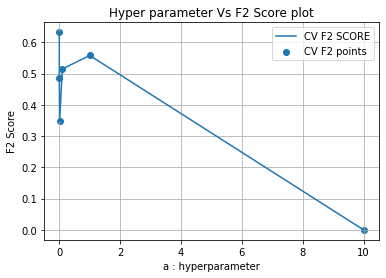

In [ ]:
plt.plot(a_list_SVM_SGD,cv_f2_score_SVM_SGD_median_data, label='CV F2 SCORE')

plt.scatter(a_list_SVM_SGD,cv_f2_score_SVM_SGD_median_data, label='CV F2 points')

plt.legend()
plt.xlabel("a : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**SVM on adasyn data**

In [ ]:
%%time
grid=run_Support_Vector_Machine_SGD(new_x_adasyn_df, y_adasyn)
grid

CPU times: user 25.2 s, sys: 232 ms, total: 25.4 s
Wall time: 3min 15s


GridSearchCV(cv=5,
             estimator=SGDClassifier(class_weight='balanced', n_jobs=-1,
                                     penalty='l1'),
             n_jobs=-1, param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

SGDClassifier(alpha=0.001, class_weight='balanced', n_jobs=-1, penalty='l1')

In [ ]:
grid.best_params_

{'alpha': 0.001}

In [ ]:
grid.best_score_

0.9284350232943241

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,{'alpha': 0.0001},0.921475
1,{'alpha': 0.001},0.928435
2,{'alpha': 0.01},0.923823
3,{'alpha': 0.1},0.898941
4,{'alpha': 1},0.667395


In [ ]:
a_list_SVM_SGD=list(results["param_alpha"])
cv_f2_score_SVM_SGD_adasyn_data=list(results["mean_test_score"])

In [ ]:
np.save('a_list_SVM_SGD.npy',a_list_SVM_SGD) 
#a_list_SVM_SGD=np.load("a_list_SVM_SGD.npy")

In [ ]:
np.save('cv_f2_score_SVM_SGD_adasyn_data.npy',cv_f2_score_SVM_SGD_adasyn_data ) 
#cv_f2_score_SVM_SGD_adasyn_data=np.load("cv_f2_score_SVM_SGD_adasyn_data.npy")

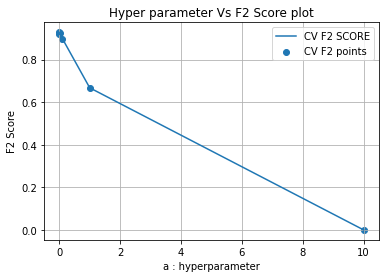

In [ ]:
plt.plot(a_list_SVM_SGD,cv_f2_score_SVM_SGD_adasyn_data, label='CV F2 SCORE')

plt.scatter(a_list_SVM_SGD,cv_f2_score_SVM_SGD_adasyn_data, label='CV F2 points')

plt.legend()
plt.xlabel("a : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**SVM on smotetomek data**

In [ ]:
%%time
grid=run_Support_Vector_Machine_SGD(new_x_smotetomek_df, y_smotetomek)
grid

CPU times: user 1min 5s, sys: 138 ms, total: 1min 6s
Wall time: 3min 5s


GridSearchCV(cv=5,
             estimator=SGDClassifier(class_weight='balanced', n_jobs=-1,
                                     penalty='l1'),
             n_jobs=-1, param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

SGDClassifier(class_weight='balanced', n_jobs=-1, penalty='l1')

In [ ]:
grid.best_params_

{'alpha': 0.0001}

In [ ]:
grid.best_score_

0.9638172755259242

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,{'alpha': 0.0001},0.963817
1,{'alpha': 0.001},0.963761
2,{'alpha': 0.01},0.950818
3,{'alpha': 0.1},0.928515
4,{'alpha': 1},0.755389


In [ ]:
a_list_SVM_SGD=list(results["param_alpha"])
cv_f2_score_SVM_SGD_smotetomek_data=list(results["mean_test_score"])

In [ ]:
np.save('a_list_SVM_SGD.npy',a_list_SVM_SGD) 
#a_list_SVM_SGD=np.load("a_list_SVM_SGD.npy")

In [ ]:
np.save('cv_f2_score_SVM_SGD_smotetomek_data.npy',cv_f2_score_SVM_SGD_smotetomek_data ) 
#cv_f2_score_SVM_SGD_smotetomek_data=np.load("cv_f2_score_SVM_SGD_smotetomek_data.npy")

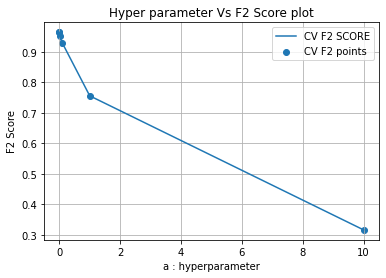

In [ ]:
plt.plot(a_list_SVM_SGD,cv_f2_score_SVM_SGD_smotetomek_data, label='CV F2 SCORE')

plt.scatter(a_list_SVM_SGD,cv_f2_score_SVM_SGD_smotetomek_data, label='CV F2 points')

plt.legend()
plt.xlabel("a : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

In [ ]:
np.sort(cv_f2_score_SVM_SGD_median_data)[::-1][0]

0.6320824038784691

In [ ]:
np.sort(cv_f2_score_SVM_SGD_adasyn_data)[::-1][0]

0.9284350232943241

In [ ]:
np.sort(cv_f2_score_SVM_SGD_smotetomek_data)[::-1][0]

0.9638172755259242

In [34]:
a_list_SVM_SGD[np.argsort(cv_f2_score_SVM_SGD_smotetomek_data)[::-1][0]]

0.0001

**Running SVM_SGD on median data with appropriate hyperparameters**

In [35]:
clf = SGDClassifier(loss='hinge',penalty='l1',alpha=0.0001,n_jobs=-1,class_weight="balanced")

#Fit with train data
clf.fit(new_standard_train_median_all_features_df, y_train_median_all_features)

#Run the prediction with test data.
y_predicted = clf.predict(new_standard_test_median_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_median_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_median_all_features, y_predicted))

f2_score :  0.6844802342606151
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11421  379
1.0           13  187


**Running SVM_SGD on adasyn data with appropriate hyperparameters**

In [35]:
clf = SGDClassifier(loss='hinge',penalty='l1',alpha=0.001,n_jobs=-1,class_weight="balanced")

#Fit with train data
clf.fit(new_standard_train_median_all_features_df, y_train_median_all_features)

#Run the prediction with test data.
y_predicted = clf.predict(new_standard_test_median_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_median_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_median_all_features, y_predicted))

f2_score :  0.6844802342606151
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11421  379
1.0           13  187


**The best value of cv score is 0.963817 with the a value of 0.0001 with smotetomek data. So I will take this value of a in my algorthim.**

In [ ]:
clf = SGDClassifier(loss='hinge',penalty='l1',alpha=0.0001,n_jobs=-1,class_weight="balanced")

#Fit with train data
clf.fit(new_x_smotetomek_df, y_smotetomek)

#Run the prediction with test data.
y_predicted = clf.predict(new_standard_test_smotetomek_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_smotetomek_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_smotetomek_all_features, y_predicted))

f2_score :  0.6499636891793755
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11402  398
1.0           21  179


### Decision Trees

In [36]:
def run_Decision_Tree(x_train, y_train):
    
    f_2_score = make_scorer(fbeta_score, pos_label=1.0 , beta=2)

    depth_range=[4,6,8,9,10,12,14,17]
    min_samples_range=[2,10,20,30,40,50]

    parameters = {'max_depth': depth_range,'min_samples_split':min_samples_range}
    
    DT=DecisionTreeClassifier(criterion='gini',class_weight="balanced")

    grid = GridSearchCV(DT, parameters, cv=5,n_jobs=-1, scoring=f_2_score)

    grid.fit(x_train, y_train) 

    return grid

**DT on median data**

In [ ]:
%%time
grid=run_Decision_Tree(new_standard_train_median_all_features_df, y_train_median_all_features)
grid

CPU times: user 5.56 s, sys: 225 ms, total: 5.78 s
Wall time: 2min 29s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 9, 10, 12, 14, 17],
                         'min_samples_split': [2, 10, 20, 30, 40, 50]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=12)

In [ ]:
grid.best_params_

{'max_depth': 12, 'min_samples_split': 2}

In [ ]:
grid.best_score_

0.8561706699053374

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'max_depth': 4, 'min_samples_split': 2}",0.788147
1,"{'max_depth': 4, 'min_samples_split': 10}",0.789392
2,"{'max_depth': 4, 'min_samples_split': 20}",0.789392
3,"{'max_depth': 4, 'min_samples_split': 30}",0.788147
4,"{'max_depth': 4, 'min_samples_split': 40}",0.789392


In [ ]:
depth_list_DT=list(results["param_max_depth"])
samples_list_DT=list(results["param_min_samples_split"])
cv_f2_score_DT_median_data=list(results["mean_test_score"])

In [ ]:
np.save('depth_list_DT.npy',depth_list_DT)
np.save('samples_list_DT.npy',samples_list_DT)

#depth_list_DT=np.load("depth_list_DT.npy")
#samples_list_DT=np.load("samples_list_DT.npy")

In [ ]:
np.save('cv_f2_score_DT_median_data.npy',cv_f2_score_DT_median_data ) 
#cv_f2_score_DT_median_data=np.load("cv_f2_score_DT_median_data.npy")

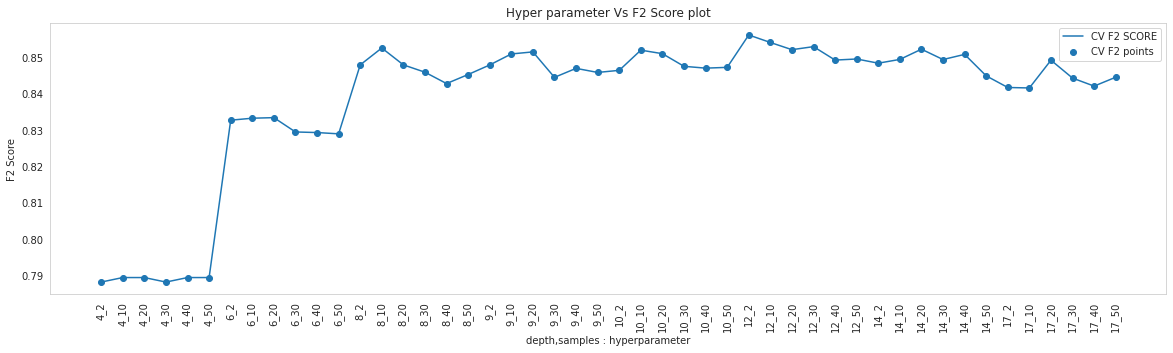

In [ ]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j) for i,j in zip(depth_list_DT,samples_list_DT)],cv_f2_score_DT_median_data, label='CV F2 SCORE')

plt.scatter([str(i)+"_"+str(j) for i,j in zip(depth_list_DT,samples_list_DT)],cv_f2_score_DT_median_data, label='CV F2 points')

plt.xticks(rotation=90)

plt.legend()
plt.xlabel("depth,samples : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**DT on adasyn data**

In [ ]:
%%time
grid=run_Decision_Tree(new_x_adasyn_df, y_adasyn)
grid

CPU times: user 18.7 s, sys: 380 ms, total: 19 s
Wall time: 9min 7s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 9, 10, 12, 14, 17],
                         'min_samples_split': [2, 10, 20, 30, 40, 50]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=12)

In [ ]:
grid.best_params_

{'max_depth': 12, 'min_samples_split': 2}

In [ ]:
grid.best_score_

0.9774154170065691

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'max_depth': 4, 'min_samples_split': 2}",0.973678
1,"{'max_depth': 4, 'min_samples_split': 10}",0.973678
2,"{'max_depth': 4, 'min_samples_split': 20}",0.973706
3,"{'max_depth': 4, 'min_samples_split': 30}",0.973678
4,"{'max_depth': 4, 'min_samples_split': 40}",0.973706


In [ ]:
depth_list_DT=list(results["param_max_depth"])
samples_list_DT=list(results["param_min_samples_split"])
cv_f2_score_DT_adasyn_data=list(results["mean_test_score"])

In [ ]:
np.save('depth_list_DT.npy',depth_list_DT)
np.save('samples_list_DT.npy',samples_list_DT)

#depth_list_DT=np.load("depth_list_DT.npy")
#samples_list_DT=np.load("samples_list_DT.npy")

In [ ]:
np.save('cv_f2_score_DT_adasyn_data.npy',cv_f2_score_DT_adasyn_data ) 
#cv_f2_score_DT_adasyn_data=np.load("cv_f2_score_DT_adasyn_data.npy")

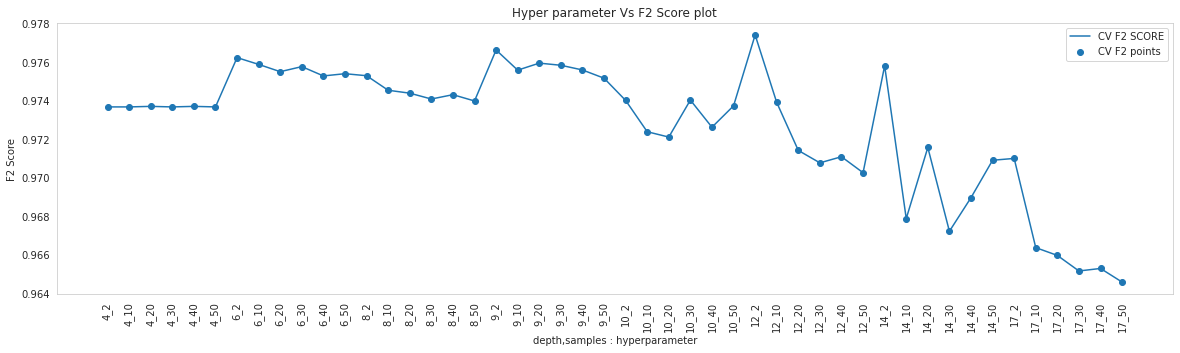

In [ ]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j) for i,j in zip(depth_list_DT,samples_list_DT)],cv_f2_score_DT_adasyn_data, label='CV F2 SCORE')

plt.scatter([str(i)+"_"+str(j) for i,j in zip(depth_list_DT,samples_list_DT)],cv_f2_score_DT_adasyn_data, label='CV F2 points')

plt.xticks(rotation=90)

plt.legend()
plt.xlabel("depth,samples : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**DT on smotetomek data**

In [ ]:
%%time
grid=run_Decision_Tree(new_x_smotetomek_df, y_smotetomek)
grid

CPU times: user 25.4 s, sys: 313 ms, total: 25.7 s
Wall time: 9min 8s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 9, 10, 12, 14, 17],
                         'min_samples_split': [2, 10, 20, 30, 40, 50]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=17)

In [ ]:
grid.best_params_

{'max_depth': 17, 'min_samples_split': 2}

In [ ]:
grid.best_score_

0.9960594883249249

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'max_depth': 4, 'min_samples_split': 2}",0.990432
1,"{'max_depth': 4, 'min_samples_split': 10}",0.990455
2,"{'max_depth': 4, 'min_samples_split': 20}",0.990432
3,"{'max_depth': 4, 'min_samples_split': 30}",0.990432
4,"{'max_depth': 4, 'min_samples_split': 40}",0.990455


In [ ]:
depth_list_DT=list(results["param_max_depth"])
samples_list_DT=list(results["param_min_samples_split"])
cv_f2_score_DT_smotetomek_data=list(results["mean_test_score"])

In [ ]:
np.save('depth_list_DT.npy',depth_list_DT)
np.save('samples_list_DT.npy',samples_list_DT)
#depth_list_DT=np.load("depth_list_DT.npy")
#samples_list_DT=np.load("samples_list_DT.npy")

In [ ]:
np.save('cv_f2_score_DT_smotetomek_data.npy',cv_f2_score_DT_smotetomek_data ) 
#cv_f2_score_DT_smotetomek_data=np.load("cv_f2_score_DT_smotetomek_data.npy")

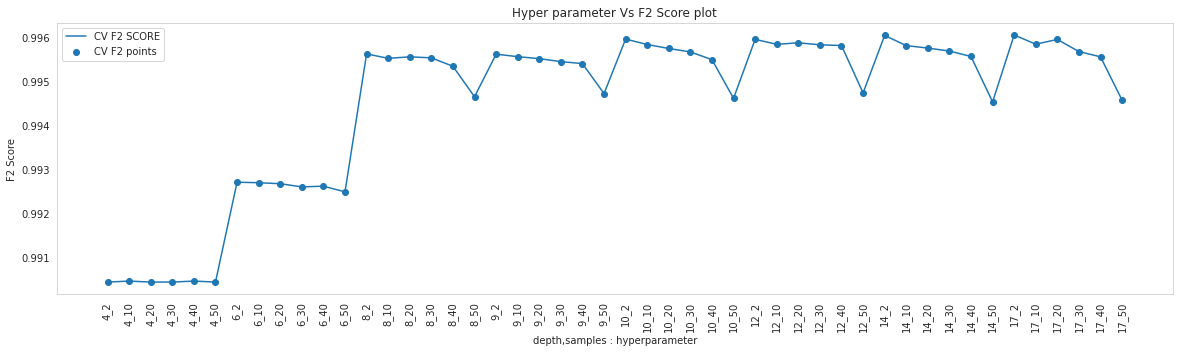

In [ ]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j) for i,j in zip(depth_list_DT,samples_list_DT)],cv_f2_score_DT_smotetomek_data, label='CV F2 SCORE')

plt.scatter([str(i)+"_"+str(j) for i,j in zip(depth_list_DT,samples_list_DT)],cv_f2_score_DT_smotetomek_data, label='CV F2 points')

plt.xticks(rotation=90)

plt.legend()
plt.xlabel("depth,samples : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

In [ ]:
np.sort(cv_f2_score_DT_median_data)[::-1][0]

0.8561706699053374

In [ ]:
np.sort(cv_f2_score_DT_adasyn_data)[::-1][0]

0.9774154170065691

In [ ]:
np.sort(cv_f2_score_DT_smotetomek_data)[::-1][0]

0.9960594883249249

In [ ]:
np.array([str(i)+"_"+str(j) for i,j in zip(depth_list_DT,samples_list_DT)])[np.argsort(cv_f2_score_DT_smotetomek_data)[::-1][0]]

'17_2'

**Running DT on median data with appropriate hyperparameters**

In [40]:
DT=DecisionTreeClassifier(criterion='gini',class_weight="balanced",max_depth=12,min_samples_split=2)

#Fit with train data
DT.fit(new_standard_train_median_all_features_df, y_train_median_all_features)

#Run the prediction with test data.
y_predicted = DT.predict(new_standard_test_median_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_median_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_median_all_features, y_predicted))

f2_score :  0.8472222222222222
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11703   97
1.0           17  183


**Running DT on adasyn data with appropriate hyperparameters**

In [41]:
DT=DecisionTreeClassifier(criterion='gini',class_weight="balanced",max_depth=12,min_samples_split=2)

#Fit with train data
DT.fit(new_x_adasyn_df, y_adasyn)

#Run the prediction with test data.
y_predicted = DT.predict(new_standard_test_adasyn_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_adasyn_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_adasyn_all_features, y_predicted))

f2_score :  0.8575445173383318
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11716   84
1.0           17  183


**The best value of cv score is 0.99605 with the parameters 17_2 with smotetomek data. So I will take this value of Depth,minimum_samples in my algorthim.**

In [ ]:
DT=DecisionTreeClassifier(criterion='gini',class_weight="balanced",max_depth=17,min_samples_split=2)

#Fit with train data
DT.fit(new_x_smotetomek_df, y_smotetomek)

#Run the prediction with test data.
y_predicted = DT.predict(new_standard_test_smotetomek_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_smotetomek_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_smotetomek_all_features, y_predicted))

f2_score :  0.855899419729207
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11743   57
1.0           23  177


### Random Forest

In [ ]:
def run_Random_Forest(x_train, y_train):
    
    f_2_score = make_scorer(fbeta_score, pos_label=1.0 , beta=2)

  
    depth_range=[16,18,20,22,24,26,28]
    n_estimators_list=[10, 50, 100, 150, 200, 300,500]
    
    parameters = {'max_depth': depth_range,'n_estimators':n_estimators_list}
            
    RF = RandomForestClassifier(criterion="gini",min_samples_split=2, min_samples_leaf=5,n_jobs=-1,class_weight="balanced")

    grid = GridSearchCV(RF, parameters, cv=5,n_jobs=-1, scoring=f_2_score)

    grid.fit(x_train, y_train) 

    return grid

**RF on median data**

In [ ]:
%%time
grid=run_Random_Forest(new_standard_train_median_all_features_df, y_train_median_all_features)
grid

CPU times: user 49.5 s, sys: 371 ms, total: 49.9 s
Wall time: 37min 57s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              min_samples_leaf=5, n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': [16, 18, 20, 22, 24, 26, 28],
                         'n_estimators': [10, 50, 100, 150, 200, 300, 500]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       min_samples_leaf=5, n_jobs=-1)

In [ ]:
grid.best_params_

{'max_depth': 18, 'n_estimators': 100}

In [ ]:
grid.best_score_

0.9022734842612415

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'max_depth': 16, 'n_estimators': 10}",0.864661
1,"{'max_depth': 16, 'n_estimators': 50}",0.893405
2,"{'max_depth': 16, 'n_estimators': 100}",0.897037
3,"{'max_depth': 16, 'n_estimators': 150}",0.896595
4,"{'max_depth': 16, 'n_estimators': 200}",0.898770


In [ ]:
depth_list_RF=list(results["param_max_depth"])
estimator_list_RF=list(results["param_n_estimators"])
cv_f2_score_RF_median_data=list(results["mean_test_score"])

In [ ]:
np.save('depth_list_RF.npy',depth_list_RF)
np.save('estimator_list_RF.npy',estimator_list_RF)
#depth_list_RF=np.load("depth_list_RF.npy")
#estimator_list_RF=np.load("estimator_list_RF.npy")

In [ ]:
np.save('cv_f2_score_RF_median_data.npy',cv_f2_score_RF_median_data ) 
#cv_f2_score_RF_median_data=np.load("cv_f2_score_RF_median_data.npy")

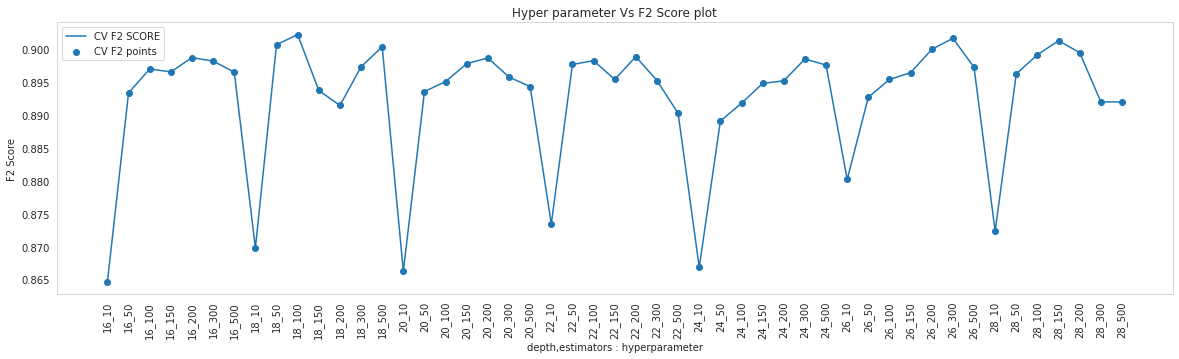

In [ ]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j) for i,j in zip(depth_list_RF,estimator_list_RF)],cv_f2_score_RF_median_data, label='CV F2 SCORE')

plt.scatter([str(i)+"_"+str(j) for i,j in zip(depth_list_RF,estimator_list_RF)],cv_f2_score_RF_median_data, label='CV F2 points')

plt.xticks(rotation=90)

plt.legend()
plt.xlabel("depth,estimators : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**RF on adasyn data**

In [ ]:
%%time
grid=run_Random_Forest(new_x_adasyn_df, y_adasyn)
grid

CPU times: user 1min, sys: 229 ms, total: 1min
Wall time: 1h 43min 12s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              min_samples_leaf=5, n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': [16, 18, 20, 22, 24, 26, 28],
                         'n_estimators': [10, 50, 100, 150, 200, 300, 500]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       min_samples_leaf=5, n_estimators=50, n_jobs=-1)

In [ ]:
grid.best_params_

{'max_depth': 18, 'n_estimators': 50}

In [ ]:
grid.best_score_

0.9947603737188798

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'max_depth': 16, 'n_estimators': 10}",0.991341
1,"{'max_depth': 16, 'n_estimators': 50}",0.993759
2,"{'max_depth': 16, 'n_estimators': 100}",0.994422
3,"{'max_depth': 16, 'n_estimators': 150}",0.993736
4,"{'max_depth': 16, 'n_estimators': 200}",0.994292


In [ ]:
depth_list_RF=list(results["param_max_depth"])
estimator_list_RF=list(results["param_n_estimators"])
cv_f2_score_RF_adasyn_data=list(results["mean_test_score"])

In [ ]:
np.save('depth_list_RF.npy',depth_list_RF)
np.save('estimator_list_RF.npy',estimator_list_RF)
#depth_list_RF=np.load("depth_list_RF.npy")
#estimator_list_RF=np.load("estimator_list_RF.npy")

In [ ]:
np.save('cv_f2_score_RF_adasyn_data.npy',cv_f2_score_RF_adasyn_data ) 
#cv_f2_score_RF_adasyn_data=np.load("cv_f2_score_RF_adasyn_data.npy")

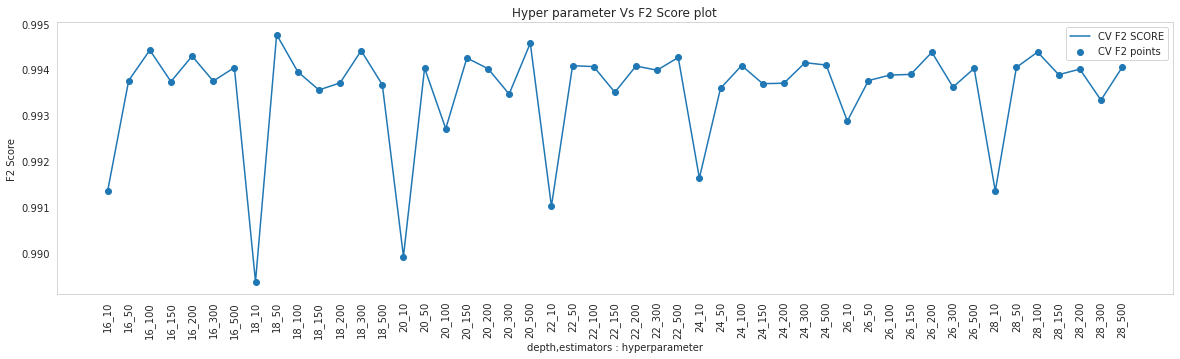

In [ ]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j) for i,j in zip(depth_list_RF,estimator_list_RF)],cv_f2_score_RF_adasyn_data, label='CV F2 SCORE')

plt.scatter([str(i)+"_"+str(j) for i,j in zip(depth_list_RF,estimator_list_RF)],cv_f2_score_RF_adasyn_data, label='CV F2 points')

plt.xticks(rotation=90)

plt.legend()
plt.xlabel("depth,estimators : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**RF on smotetomek data**

In [ ]:
%%time
grid=run_Random_Forest(new_x_smotetomek_df, y_smotetomek)
grid

CPU times: user 2min 31s, sys: 197 ms, total: 2min 31s
Wall time: 1h 51min 15s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              min_samples_leaf=5, n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': [16, 18, 20, 22, 24, 26, 28],
                         'n_estimators': [10, 50, 100, 150, 200, 300, 500]},
             scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [ ]:
grid.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=24,
                       min_samples_leaf=5, n_jobs=-1)

In [ ]:
grid.best_params_

{'max_depth': 24, 'n_estimators': 100}

In [ ]:
grid.best_score_

0.9990234723307889

In [ ]:
results = pd.DataFrame.from_dict(grid.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'max_depth': 16, 'n_estimators': 10}",0.998313
1,"{'max_depth': 16, 'n_estimators': 50}",0.998646
2,"{'max_depth': 16, 'n_estimators': 100}",0.998668
3,"{'max_depth': 16, 'n_estimators': 150}",0.998764
4,"{'max_depth': 16, 'n_estimators': 200}",0.998741


In [ ]:
depth_list_RF=list(results["param_max_depth"])
estimator_list_RF=list(results["param_n_estimators"])
cv_f2_score_RF_smotetomek_data=list(results["mean_test_score"])

In [ ]:
np.save('depth_list_RF.npy',depth_list_RF)
np.save('estimator_list_RF.npy',estimator_list_RF)
#depth_list_RF=np.load("depth_list_RF.npy")
#estimator_list_RF=np.load("estimator_list_RF.npy")

In [ ]:
np.save('cv_f2_score_RF_smotetomek_data.npy',cv_f2_score_RF_smotetomek_data ) 
#cv_f2_score_RF_smotetomek_data=np.load("cv_f2_score_RF_smotetomek_data.npy")

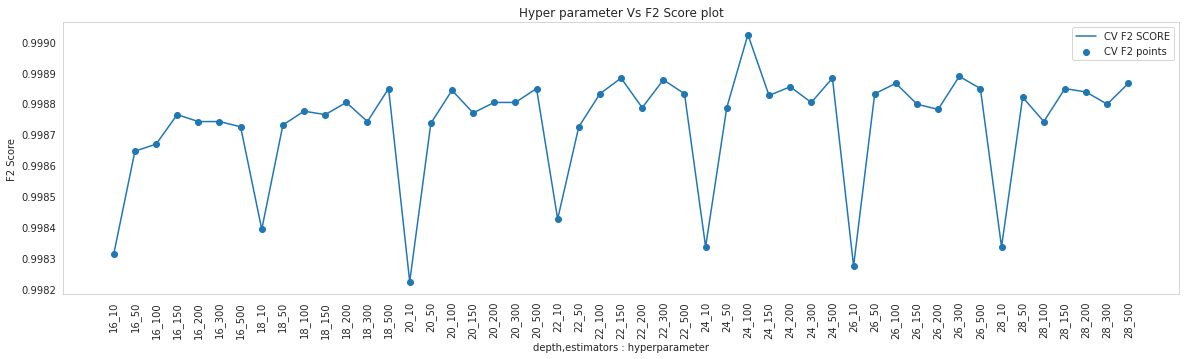

In [ ]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j) for i,j in zip(depth_list_RF,estimator_list_RF)],cv_f2_score_RF_smotetomek_data, label='CV F2 SCORE')

plt.scatter([str(i)+"_"+str(j) for i,j in zip(depth_list_RF,estimator_list_RF)],cv_f2_score_RF_smotetomek_data, label='CV F2 points')

plt.xticks(rotation=90)

plt.legend()
plt.xlabel("depth,estimators : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

In [ ]:
np.sort(cv_f2_score_RF_median_data)[::-1][0]

0.9022734842612415

In [ ]:
np.sort(cv_f2_score_RF_adasyn_data)[::-1][0]

0.9947603737188798

In [ ]:
np.sort(cv_f2_score_RF_smotetomek_data)[::-1][0]

0.9990234723307889

In [ ]:
np.array([str(i)+"_"+str(j) for i,j in zip(depth_list_RF,estimator_list_RF)])[np.argsort(cv_f2_score_RF_smotetomek_data)[::-1][0]]

'24_100'

**Running RF on median data with appropriate hyperparameters**

In [42]:
RF = RandomForestClassifier(criterion="gini",min_samples_split=2, min_samples_leaf=5,
                            n_jobs=-1,class_weight="balanced",max_depth=18,n_estimators=100)

#Fit with train data
RF.fit(new_standard_train_median_all_features_df, y_train_median_all_features)

#Run the prediction with test data.
y_predicted = RF.predict(new_standard_test_median_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_median_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_median_all_features, y_predicted))

f2_score :  0.9163346613545816
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11780   20
1.0           16  184


**Running RF on adasyn data with appropriate hyperparameters**

In [43]:
RF = RandomForestClassifier(criterion="gini",min_samples_split=2, min_samples_leaf=5,
                            n_jobs=-1,class_weight="balanced",max_depth=18,n_estimators=50)

#Fit with train data
RF.fit(new_x_adasyn_df,y_adasyn)

#Run the prediction with test data.
y_predicted = RF.predict(new_standard_test_adasyn_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_adasyn_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_adasyn_all_features, y_predicted))

f2_score :  0.9121621621621623
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11753   47
1.0           11  189


**The best value of cv score is 0.999023 with the a value of '24_100' with smotetomek data. So I will take this value of depth and estimators in my algorthim.**

In [ ]:
RF = RandomForestClassifier(criterion="gini",min_samples_split=2, min_samples_leaf=5,
                            n_jobs=-1,class_weight="balanced",max_depth=24,n_estimators=100)

#Fit with train data
RF.fit(new_x_smotetomek_df, y_smotetomek)

#Run the prediction with test data.
y_predicted = RF.predict(new_standard_test_smotetomek_all_features_df)

#Get the F2 Score with test data.
f2_score=fbeta_score(y_test_smotetomek_all_features, y_predicted, beta=2)
print("f2_score : ",f2_score)
print("confusion_matrix : \n",confusion_matrix(y_test_smotetomek_all_features, y_predicted))

f2_score :  0.9289883268482491
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11763   37
1.0            9  191


### GBDT

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [31]:
def run_GBDT_XGB(x_train, y_train):
    
    f_2_score = make_scorer(fbeta_score, pos_label=1.0, beta=2)

    depth_range=[4, 6, 8, 10,12,14]
    n_estimators_list=[50,100, 200, 300, 500, 1000]
    learning_rate=[.0001,.001,.01,.05,.10,.20,.30]

    parameters = {'max_depth': depth_range,'n_estimators':n_estimators_list,
                 'learning_rate':learning_rate}
            
    GBDT = XGBClassifier(nthread=-1,tree_method='gpu_hist',n_jobs=-1)

    rand = RandomizedSearchCV(GBDT, parameters, cv=5,n_jobs=3, scoring=f_2_score)

    rand.fit(x_train, y_train) 

    return rand

**GBDT on median data**

In [ ]:
%%time
rand=run_GBDT_XGB(new_standard_train_median_all_features_df, y_train_median_all_features)

In [ ]:
rand.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=300, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

In [ ]:
rand.best_params_

{'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.3}

In [ ]:
rand.best_score_

0.9395437457866332

In [ ]:
results = pd.DataFrame.from_dict(rand.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",0.937123
1,"{'n_estimators': 100, 'max_depth': 12, 'learni...",0.908650
2,"{'n_estimators': 500, 'max_depth': 6, 'learnin...",0.935351
3,"{'n_estimators': 100, 'max_depth': 12, 'learni...",0.826143
4,"{'n_estimators': 300, 'max_depth': 12, 'learni...",0.928424


In [ ]:
depth_list_GBDT_XGB=list(results["param_max_depth"])
estimator_list_GBDT_XGB=list(results["param_n_estimators"])
learning_rate_list_GBDT_XGB=list(results["param_learning_rate"])
cv_f2_score_GBDT_XGB_median_data=list(results["mean_test_score"])

In [ ]:
np.save('depth_list_GBDT_XGB.npy',depth_list_GBDT_XGB)
np.save('estimator_list_GBDT_XGB.npy',estimator_list_GBDT_XGB)
np.save('learning_rate_list_GBDT_XGB.npy',learning_rate_list_GBDT_XGB)
#depth_list_GBDT_XGB=np.load('depth_list_GBDT_XGB.npy')
#estimator_list_GBDT_XGB=np.load('estimator_list_GBDT_XGB.npy')
#learning_rate_list_GBDT_XGB=np.load('learning_rate_list_GBDT_XGB.npy')

In [ ]:
np.save('cv_f2_score_GBDT_XGB_median_data.npy',cv_f2_score_GBDT_XGB_median_data ) 
#cv_f2_score_GBDT_XGB_median_data=np.load('cv_f2_score_GBDT_XGB_median_data.npy')

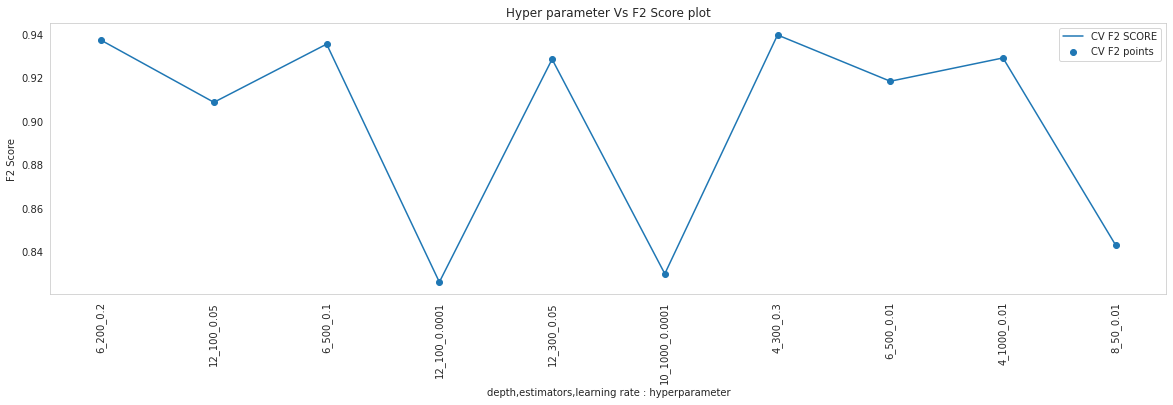

In [ ]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j)+"_"+str(k) for i,j,k in zip(depth_list_GBDT_XGB,estimator_list_GBDT_XGB,learning_rate_list_GBDT_XGB)],cv_f2_score_GBDT_XGB_median_data, label='CV F2 SCORE')
plt.scatter([str(i)+"_"+str(j)+"_"+str(k) for i,j,k in zip(depth_list_GBDT_XGB,estimator_list_GBDT_XGB,learning_rate_list_GBDT_XGB)],cv_f2_score_GBDT_XGB_median_data, label='CV F2 points')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel("depth,estimators,learning rate : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**GBDT on adasyn data**

In [32]:
%%time
rand=run_GBDT_XGB(new_x_adasyn_df, y_adasyn)
rand

CPU times: user 1min 1s, sys: 321 ms, total: 1min 2s
Wall time: 21min 48s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [33]:
rand.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=500, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

In [34]:
rand.best_params_

{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.05}

In [35]:
rand.best_score_

0.9962555722147115

In [36]:
results = pd.DataFrame.from_dict(rand.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'n_estimators': 50, 'max_depth': 10, 'learnin...",0.987538
1,"{'n_estimators': 200, 'max_depth': 8, 'learnin...",0.996063
2,"{'n_estimators': 50, 'max_depth': 10, 'learnin...",0.980611
3,"{'n_estimators': 50, 'max_depth': 4, 'learning...",0.971709
4,"{'n_estimators': 500, 'max_depth': 8, 'learnin...",0.979073


In [41]:
depth_list_GBDT_XGB_adasyn=list(results["param_max_depth"])
estimator_list_GBDT_XGB_adasyn=list(results["param_n_estimators"])
learning_rate_list_GBDT_XGB_adasyn=list(results["param_learning_rate"])
cv_f2_score_GBDT_XGB_adasyn_data=list(results["mean_test_score"])

In [45]:
np.save('depth_list_GBDT_XGB_adasyn.npy',depth_list_GBDT_XGB_adasyn)
np.save('estimator_list_GBDT_XGB_adasyn.npy',estimator_list_GBDT_XGB_adasyn)
np.save('learning_rate_list_GBDT_XGB_adasyn.npy',learning_rate_list_GBDT_XGB_adasyn)
#depth_list_GBDT_XGB_adasyn=np.load('depth_list_GBDT_XGB_adasyn.npy')
#estimator_list_GBDT_XGB_adasyn=np.load('estimator_list_GBDT_XGB_adasyn.npy')
#learning_rate_list_GBDT_XGB_adasyn=np.load('learning_rate_list_GBDT_XGB_adasyn.npy')

In [46]:
np.save('cv_f2_score_GBDT_XGB_adasyn_data.npy',cv_f2_score_GBDT_XGB_adasyn_data ) 
#cv_f2_score_GBDT_XGB_adasyn_data=np.load('cv_f2_score_GBDT_XGB_adasyn_data.npy')

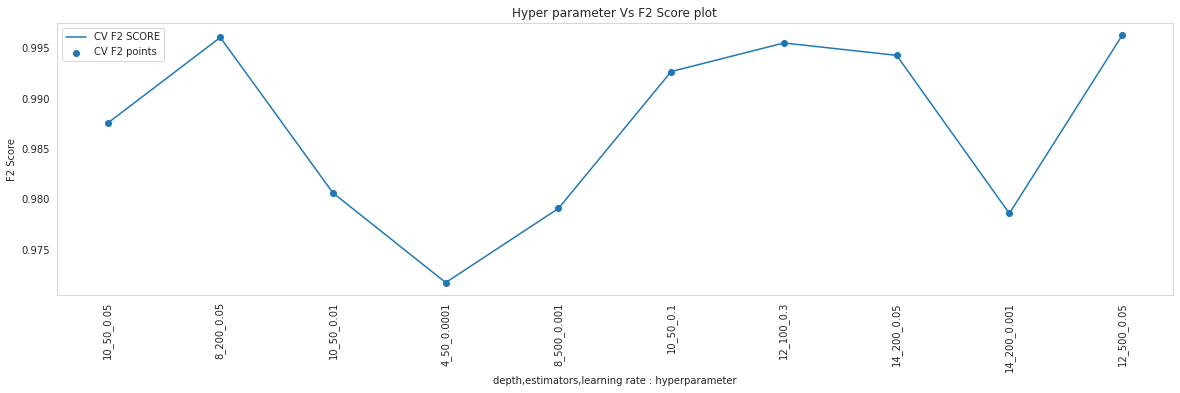

In [47]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j)+"_"+str(k) for i,j,k in zip(depth_list_GBDT_XGB_adasyn,estimator_list_GBDT_XGB_adasyn,learning_rate_list_GBDT_XGB_adasyn)],cv_f2_score_GBDT_XGB_adasyn_data, label='CV F2 SCORE')
plt.scatter([str(i)+"_"+str(j)+"_"+str(k) for i,j,k in zip(depth_list_GBDT_XGB_adasyn,estimator_list_GBDT_XGB_adasyn,learning_rate_list_GBDT_XGB_adasyn)],cv_f2_score_GBDT_XGB_adasyn_data, label='CV F2 points')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel("depth,estimators,learning rate : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**GBDT on smotetomek data**

In [48]:
%%time
rand=run_GBDT_XGB(new_x_smotetomek_df, y_smotetomek)
rand

CPU times: user 34 s, sys: 431 ms, total: 34.5 s
Wall time: 20min 20s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [49]:
rand.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=500, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

In [50]:
rand.best_params_

{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1}

In [51]:
rand.best_score_

0.9994408534502123

In [52]:
results = pd.DataFrame.from_dict(rand.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'n_estimators': 200, 'max_depth': 12, 'learni...",0.995564
1,"{'n_estimators': 50, 'max_depth': 8, 'learning...",0.999068
2,"{'n_estimators': 500, 'max_depth': 14, 'learni...",0.995123
3,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",0.999108
4,"{'n_estimators': 500, 'max_depth': 8, 'learnin...",0.999441


In [57]:
depth_list_GBDT_XGB_smotetomek=list(results["param_max_depth"])
estimator_list_GBDT_XGB_smotetomek=list(results["param_n_estimators"])
learning_rate_list_GBDT_XGB_smotetomek=list(results["param_learning_rate"])
cv_f2_score_GBDT_XGB_smotetomek_data=list(results["mean_test_score"])

In [58]:
np.save('depth_list_GBDT_XGB_smotetomek.npy',depth_list_GBDT_XGB_smotetomek)
np.save('estimator_list_GBDT_XGB_smotetomek.npy',estimator_list_GBDT_XGB_smotetomek)
np.save('learning_rate_list_GBDT_XGB_smotetomek.npy',learning_rate_list_GBDT_XGB_smotetomek)
#depth_list_GBDT_XGB_smotetomek=np.load('depth_list_GBDT_XGB_smotetomek.npy')
#estimator_list_GBDT_XGB_smotetomek=np.load('estimator_list_GBDT_XGB_smotetomek.npy')
#learning_rate_list_GBDT_XGB_smotetomek=np.load('learning_rate_list_GBDT_XGB_smotetomek.npy')

In [59]:
np.save('cv_f2_score_GBDT_XGB_smotetomek_data.npy',cv_f2_score_GBDT_XGB_smotetomek_data ) 
#cv_f2_score_GBDT_XGB_smotetomek_data=np.load('cv_f2_score_GBDT_XGB_smotetomek_data.npy')

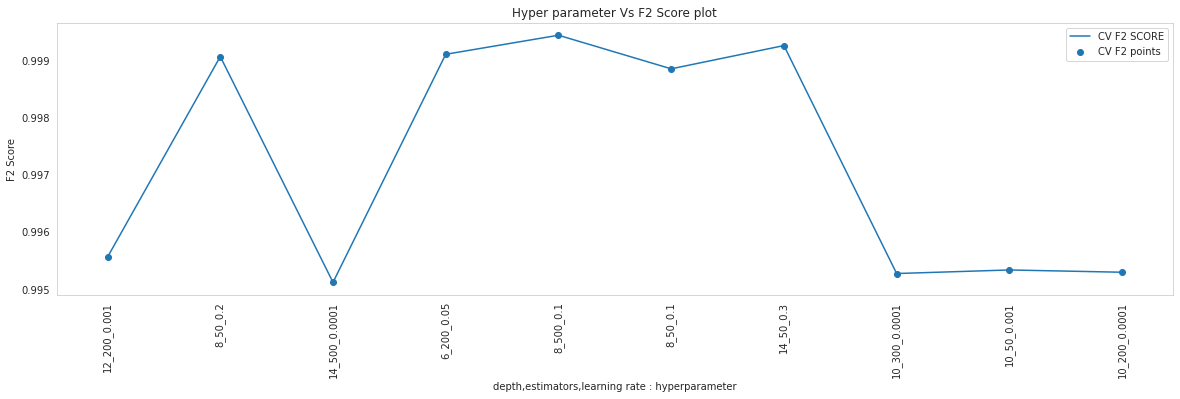

In [60]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j)+"_"+str(k) for i,j,k in zip(depth_list_GBDT_XGB_smotetomek,estimator_list_GBDT_XGB_smotetomek,learning_rate_list_GBDT_XGB_smotetomek)],cv_f2_score_GBDT_XGB_smotetomek_data, label='CV F2 SCORE')
plt.scatter([str(i)+"_"+str(j)+"_"+str(k) for i,j,k in zip(depth_list_GBDT_XGB_smotetomek,estimator_list_GBDT_XGB_smotetomek,learning_rate_list_GBDT_XGB_smotetomek)],cv_f2_score_GBDT_XGB_smotetomek_data, label='CV F2 points')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel("depth,estimators,learning rate : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

In [29]:
np.sort(cv_f2_score_GBDT_XGB_median_data)[::-1][0]

0.9395437457866332

In [30]:
np.array([str(i)+"_"+str(j)+"_"+str(k) for i,j,k in zip(depth_list_GBDT_XGB,estimator_list_GBDT_XGB,learning_rate_list_GBDT_XGB)])[np.argsort(cv_f2_score_GBDT_XGB_median_data)[::-1][0]]

'4_300_0.3'

In [70]:
np.sort(cv_f2_score_GBDT_XGB_adasyn_data)[::-1][0]

0.9962555722147115

In [31]:
np.array([str(i)+"_"+str(j)+"_"+str(k) for i,j,k in zip(depth_list_GBDT_XGB_adasyn,estimator_list_GBDT_XGB_adasyn,learning_rate_list_GBDT_XGB_adasyn)])[np.argsort(cv_f2_score_GBDT_XGB_adasyn_data)[::-1][0]]

'12_500_0.05'

In [75]:
np.sort(cv_f2_score_GBDT_XGB_smotetomek_data)[::-1][0]

0.9994408534502123

In [74]:
np.array([str(i)+"_"+str(j)+"_"+str(k) for i,j,k in zip(depth_list_GBDT_XGB_smotetomek,estimator_list_GBDT_XGB_smotetomek,learning_rate_list_GBDT_XGB_smotetomek)])[np.argsort(cv_f2_score_GBDT_XGB_smotetomek_data)[::-1][0]]

'8_500_0.1'

**Running GBDT_XGB on median data with appropriate hyperparameters**

In [44]:
GBDT = XGBClassifier(nthread=-1, tree_method='gpu_hist',n_jobs=-1,n_estimators= 300,max_depth=4,learning_rate=0.3)

GBDT.fit(new_standard_train_median_all_features_df, y_train_median_all_features)

y_predicted=GBDT.predict(new_standard_test_median_all_features_df)

f2_score=fbeta_score(y_test_median_all_features, y_predicted, pos_label=1.0, beta=2)

print("f2_score : ",f2_score)

print("confusion_matrix : \n",confusion_matrix(y_test_median_all_features, y_predicted))

f2_score :  0.9718026183282982
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11800    0
1.0            7  193


**Running GBDT_XGB on adasyn data with appropriate hyperparameters**

In [45]:
GBDT = XGBClassifier(nthread=-1, tree_method='gpu_hist',n_jobs=-1,n_estimators= 500,max_depth=12,learning_rate=0.05)

GBDT.fit(new_x_adasyn_df, y_adasyn)

y_predicted=GBDT.predict(new_standard_test_adasyn_all_features_df)

f2_score=fbeta_score(y_test_adasyn_all_features, y_predicted, pos_label=1.0, beta=2)

print("f2_score : ",f2_score)

print("confusion_matrix : \n",confusion_matrix(y_test_adasyn_all_features, y_predicted))

f2_score :  0.9632571996027806
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11787   13
1.0            6  194


**The best value of cv score is 0.99944 with the parameters 8_500_0.1 with smotetomek data. So I will take this value of Depth,minimum_samples and learning rate in my algorthim.**

In [17]:
GBDT = XGBClassifier(nthread=-1, tree_method='gpu_hist',n_jobs=-1,n_estimators= 500,max_depth=8,learning_rate=0.1)

GBDT.fit(new_x_smotetomek_df, y_smotetomek)

y_predicted=GBDT.predict(new_standard_test_smotetomek_all_features_df)

f2_score=fbeta_score(y_test_smotetomek_all_features, y_predicted, pos_label=1.0, beta=2)

print("f2_score : ",f2_score)

print("confusion_matrix : \n",confusion_matrix(y_test_smotetomek_all_features, y_predicted))

f2_score :  0.9720837487537389
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11792    8
1.0            5  195


### Adaboost

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

In [50]:
def run_AdaBoost(x_train, y_train):
    
    f_2_score = make_scorer(fbeta_score, pos_label=1.0, beta=2)

    n_estimators_list=[50,100, 200, 300, 500, 1000]
    learning_rate=[.0001,.001,.01,.05,.10,.20,.30,.50,.70,.90]
    
    parameters = {'n_estimators':n_estimators_list,
                 'learning_rate':learning_rate}
    
    clf = AdaBoostClassifier()

    rand = RandomizedSearchCV(clf, parameters, cv=5,n_jobs=-1, scoring=f_2_score)

    rand.fit(x_train, y_train) 

    return rand

**AdaBoost on median data**

In [51]:
%%time
rand=run_AdaBoost(new_standard_train_median_all_features_df, y_train_median_all_features)
rand

CPU times: user 15min 10s, sys: 969 ms, total: 15min 11s
Wall time: 51min 2s


RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.05, 0.1, 0.2, 0.3,
                                                          0.5, 0.7, 0.9],
                                        'n_estimators': [50, 100, 200, 300, 500,
                                                         1000]},
                   scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [57]:
rand.best_estimator_

AdaBoostClassifier(learning_rate=0.3, n_estimators=1000)

In [58]:
rand.best_params_

{'n_estimators': 1000, 'learning_rate': 0.3}

In [59]:
rand.best_score_

0.9268327781099532

In [60]:
results = pd.DataFrame.from_dict(rand.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'n_estimators': 200, 'learning_rate': 0.3}",0.887615
1,"{'n_estimators': 50, 'learning_rate': 0.0001}",0.691494
2,"{'n_estimators': 300, 'learning_rate': 0.7}",0.921753
3,"{'n_estimators': 500, 'learning_rate': 0.7}",0.925532
4,"{'n_estimators': 100, 'learning_rate': 0.5}",0.877913


In [66]:
estimator_list_Adaboost=list(results["param_n_estimators"])
learning_rate_list_Adaboost=list(results["param_learning_rate"])
cv_f2_score_Adaboost_median_data=list(results["mean_test_score"])

In [67]:
np.save('estimator_list_Adaboost.npy',estimator_list_Adaboost)
np.save('learning_rate_list_Adaboost.npy',learning_rate_list_Adaboost)
#estimator_list_Adaboost=np.load('estimator_list_Adaboost.npy')
#learning_rate_list_Adaboost=np.load('learning_rate_list_Adaboost.npy')

In [68]:
np.save('cv_f2_score_Adaboost_median_data.npy',cv_f2_score_Adaboost_median_data ) 
#cv_f2_score_Adaboost_median_data=np.load('cv_f2_score_Adaboost_median_data.npy')

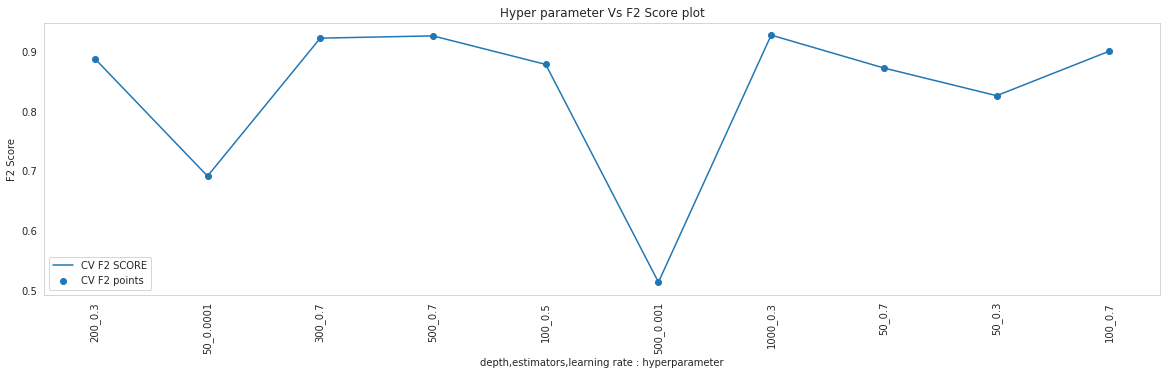

In [71]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j) for i,j in zip(estimator_list_Adaboost,learning_rate_list_Adaboost)],cv_f2_score_Adaboost_median_data, label='CV F2 SCORE')
plt.scatter([str(i)+"_"+str(j) for i,j in zip(estimator_list_Adaboost,learning_rate_list_Adaboost)],cv_f2_score_Adaboost_median_data, label='CV F2 points')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel("depth,estimators,learning rate : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**AdaBoost on adasyn data**

In [72]:
%%time
rand=run_AdaBoost(new_x_adasyn_df, y_adasyn)
rand

CPU times: user 6min 6s, sys: 1.2 s, total: 6min 7s
Wall time: 1h 13min 29s


RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.05, 0.1, 0.2, 0.3,
                                                          0.5, 0.7, 0.9],
                                        'n_estimators': [50, 100, 200, 300, 500,
                                                         1000]},
                   scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [73]:
rand.best_estimator_

AdaBoostClassifier(learning_rate=0.5, n_estimators=200)

In [74]:
rand.best_params_

{'n_estimators': 200, 'learning_rate': 0.5}

In [75]:
rand.best_score_

0.9940109523031383

In [76]:
results = pd.DataFrame.from_dict(rand.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'n_estimators': 300, 'learning_rate': 0.2}",0.991492
1,"{'n_estimators': 100, 'learning_rate': 0.01}",0.929967
2,"{'n_estimators': 300, 'learning_rate': 0.001}",0.892946
3,"{'n_estimators': 200, 'learning_rate': 0.1}",0.983556
4,"{'n_estimators': 200, 'learning_rate': 0.001}",0.887886


In [82]:
estimator_list_Adaboost_adasyn_data=list(results["param_n_estimators"])
learning_rate_list_Adaboost_adasyn_data=list(results["param_learning_rate"])
cv_f2_score_Adaboost_adasyn_data=list(results["mean_test_score"])

In [83]:
np.save('estimator_list_Adaboost_adasyn_data.npy',estimator_list_Adaboost_adasyn_data)
np.save('learning_rate_list_Adaboost_adasyn_data.npy',learning_rate_list_Adaboost_adasyn_data)
#estimator_list_Adaboost_adasyn_data=np.load('estimator_list_Adaboost_adasyn_data.npy')
#learning_rate_list_Adaboost_adasyn_data=np.load('learning_rate_list_Adaboost_adasyn_data.npy')

In [84]:
np.save('cv_f2_score_Adaboost_adasyn_data.npy',cv_f2_score_Adaboost_adasyn_data ) 
#cv_f2_score_Adaboost_adasyn_data=np.load('cv_f2_score_Adaboost_adasyn_data.npy')

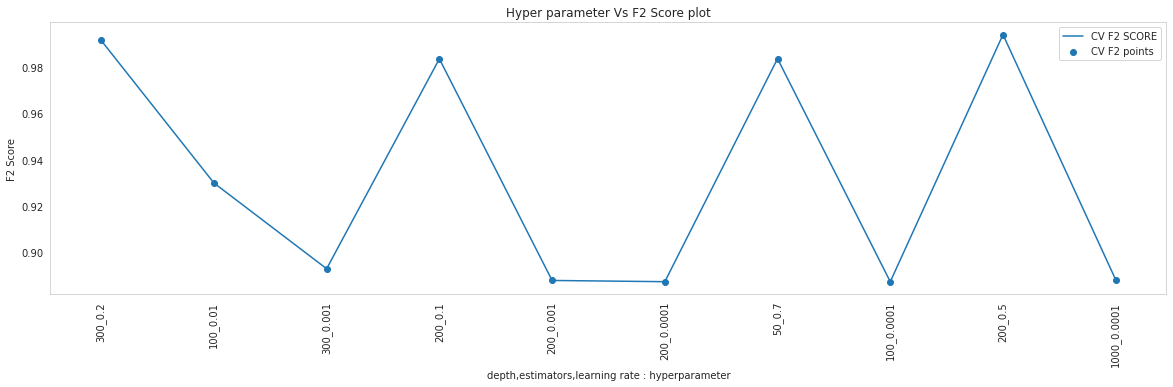

In [85]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j) for i,j in zip(estimator_list_Adaboost_adasyn_data,learning_rate_list_Adaboost_adasyn_data)],cv_f2_score_Adaboost_adasyn_data, label='CV F2 SCORE')
plt.scatter([str(i)+"_"+str(j) for i,j in zip(estimator_list_Adaboost_adasyn_data,learning_rate_list_Adaboost_adasyn_data)],cv_f2_score_Adaboost_adasyn_data, label='CV F2 points')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel("depth,estimators,learning rate : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

**AdaBoost on smotetomek data**

In [86]:
%%time
rand=run_AdaBoost(new_x_smotetomek_df, y_smotetomek)
rand

CPU times: user 16min 41s, sys: 1.17 s, total: 16min 42s
Wall time: 1h 22min 42s


RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.05, 0.1, 0.2, 0.3,
                                                          0.5, 0.7, 0.9],
                                        'n_estimators': [50, 100, 200, 300, 500,
                                                         1000]},
                   scoring=make_scorer(fbeta_score, pos_label=1.0, beta=2))

In [87]:
rand.best_estimator_

AdaBoostClassifier(learning_rate=0.7, n_estimators=1000)

In [88]:
rand.best_params_

{'n_estimators': 1000, 'learning_rate': 0.7}

In [89]:
rand.best_score_

0.9993505458615074

In [90]:
results = pd.DataFrame.from_dict(rand.cv_results_)
results[0:5][["params","mean_test_score"]]

,params,mean_test_score
0,"{'n_estimators': 1000, 'learning_rate': 0.7}",0.999351
1,"{'n_estimators': 200, 'learning_rate': 0.1}",0.986327
2,"{'n_estimators': 300, 'learning_rate': 0.9}",0.999085
3,"{'n_estimators': 50, 'learning_rate': 0.1}",0.973251
4,"{'n_estimators': 50, 'learning_rate': 0.01}",0.946198


In [91]:
estimator_list_Adaboost_smotetomek_data=list(results["param_n_estimators"])
learning_rate_list_Adaboost_smotetomek_data=list(results["param_learning_rate"])
cv_f2_score_Adaboost_smotetomek_data=list(results["mean_test_score"])

In [92]:
np.save('estimator_list_Adaboost_smotetomek_data.npy',estimator_list_Adaboost_smotetomek_data)
np.save('learning_rate_list_Adaboost_smotetomek_data.npy',learning_rate_list_Adaboost_smotetomek_data)
#estimator_list_Adaboost_smotetomek_data=np.load('estimator_list_Adaboost_smotetomek_data.npy')
#learning_rate_list_Adaboost_smotetomek_data=np.load('learning_rate_list_Adaboost_smotetomek_data.npy')

In [93]:
np.save('cv_f2_score_Adaboost_smotetomek_data.npy',cv_f2_score_Adaboost_smotetomek_data ) 
#cv_f2_score_Adaboost_smotetomek_data=np.load('cv_f2_score_Adaboost_smotetomek_data.npy')

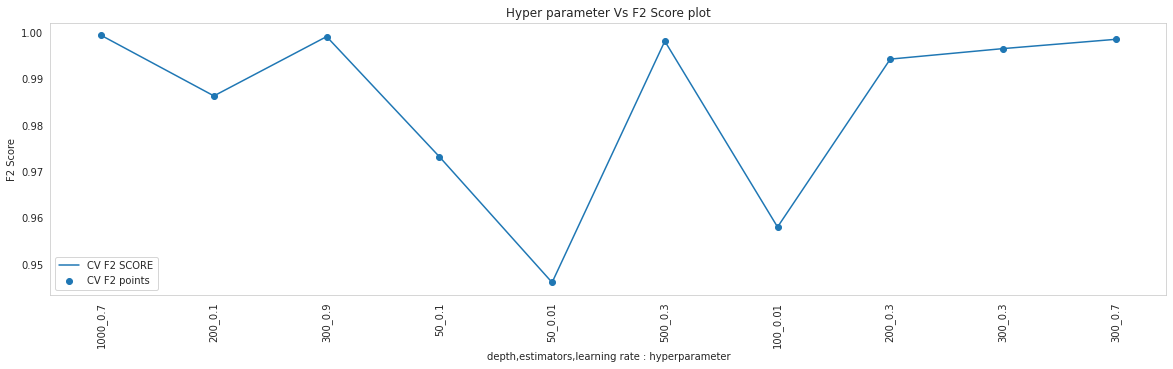

In [94]:
plt.figure(figsize=(20,5))
sns.set_style('whitegrid')

plt.plot([str(i)+"_"+str(j) for i,j in zip(estimator_list_Adaboost_smotetomek_data,learning_rate_list_Adaboost_smotetomek_data)],cv_f2_score_Adaboost_smotetomek_data, label='CV F2 SCORE')
plt.scatter([str(i)+"_"+str(j) for i,j in zip(estimator_list_Adaboost_smotetomek_data,learning_rate_list_Adaboost_smotetomek_data)],cv_f2_score_Adaboost_smotetomek_data, label='CV F2 points')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel("depth,estimators,learning rate : hyperparameter")
plt.ylabel("F2 Score")
plt.title("Hyper parameter Vs F2 Score plot")
plt.grid()
plt.show()

In [98]:
np.sort(cv_f2_score_Adaboost_median_data)[::-1][0]

0.9268327781099532

In [100]:
np.array([str(i)+"_"+str(j) for i,j in zip(estimator_list_Adaboost,learning_rate_list_Adaboost)])[np.argsort(cv_f2_score_Adaboost_median_data)[::-1][0]]

'1000_0.3'

In [101]:
np.sort(cv_f2_score_Adaboost_adasyn_data)[::-1][0]

0.9940109523031383

In [104]:
np.array([str(i)+"_"+str(j) for i,j in zip(estimator_list_Adaboost_adasyn_data,learning_rate_list_Adaboost_adasyn_data)])[np.argsort(cv_f2_score_Adaboost_adasyn_data)[::-1][0]]

'200_0.5'

In [105]:
np.sort(cv_f2_score_Adaboost_smotetomek_data)[::-1][0]

0.9993505458615074

In [106]:
np.array([str(i)+"_"+str(j) for i,j in zip(estimator_list_Adaboost_smotetomek_data,learning_rate_list_Adaboost_smotetomek_data)])[np.argsort(cv_f2_score_Adaboost_smotetomek_data)[::-1][0]]

'1000_0.7'

**Running GBDT_Adaboost on median data with appropriate hyperparameters**

In [47]:
AdaBoost = AdaBoostClassifier(n_estimators=1000,learning_rate=0.3)

AdaBoost.fit(new_standard_train_median_all_features_df, y_train_median_all_features)

y_predicted=AdaBoost.predict(new_standard_test_median_all_features_df)

f2_score=fbeta_score(y_test_median_all_features, y_predicted, pos_label=1.0, beta=2)

print("f2_score : ",f2_score)

print("confusion_matrix : \n",confusion_matrix(y_test_median_all_features, y_predicted))

f2_score :  0.9444444444444445
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11797    3
1.0           13  187


**Running GBDT_Adaboost on adasyn data with appropriate hyperparameters**

In [48]:
AdaBoost = AdaBoostClassifier(n_estimators=200,learning_rate=0.5)

AdaBoost.fit(new_x_adasyn_df, y_adasyn)

y_predicted=AdaBoost.predict(new_standard_test_adasyn_all_features_df)

f2_score=fbeta_score(y_test_adasyn_all_features, y_predicted, pos_label=1.0, beta=2)

print("f2_score : ",f2_score)

print("confusion_matrix : \n",confusion_matrix(y_test_adasyn_all_features, y_predicted))

f2_score :  0.9125117591721542
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11731   69
1.0            6  194


**The best value of cv score is 0.99935 with the parameters 1000_0.7 with smotetomek data. So I will take this value of number of trees and learning rate in my algorthim.**

In [107]:
AdaBoost = AdaBoostClassifier(n_estimators=1000,learning_rate=0.7)

AdaBoost.fit(new_x_smotetomek_df, y_smotetomek)

y_predicted=AdaBoost.predict(new_standard_test_smotetomek_all_features_df)

f2_score=fbeta_score(y_test_smotetomek_all_features, y_predicted, pos_label=1.0, beta=2)

print("f2_score : ",f2_score)

print("confusion_matrix : \n",confusion_matrix(y_test_smotetomek_all_features, y_predicted))

f2_score :  0.9643916913946587
confusion_matrix : 
 Predicted    0.0  1.0
True                 
0.0        11784   16
1.0            5  195


**Conclusion :** I am able to minimize the False Negatives and I get the best score with Gradient Boosted Decision Trees with median imputed data.